<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/GuidedGradCAM_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
#labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [ ]:
#image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # bens hpc file path
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

In [ ]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3140,0.875,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3143.png


In [ ]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,


In [ ]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,


In [ ]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["angle"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [ ]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 131, validation size: 33


In [ ]:
validation_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# #only performing augmentation on training data as want validation/test data to reflect kaggle test set
# seed = (6,9)
# train_dataset = train_dataset.map(
#       lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_contrast(image,0.8,1.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_hue(image,0.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_saturation(image,0.8,1.2,seed),label)
# ).take(5
# )

checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 0.6875
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.4375
image shape:  (224, 224, 3)
label: 0.4375


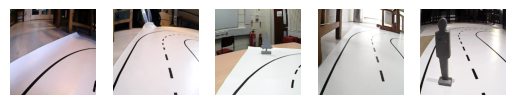

In [ ]:
f, axarr = plt.subplots(1,5)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 5:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

In [ ]:
niter = 200

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

iter: 0, train_loss: 0.018, train_MSE: 0.040, val_loss: 0.013, val_MSE: 0.036


In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

In [ ]:
dropoutrate = 0.2
num_classes = 1
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = True # UNFREEZE mbnet layers

model.summary() # print the model

In [ ]:
model.load_weights('/home/apyba3/car_frozen_regression.weights.h5')

In [ ]:
niter = 50

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

In [ ]:
model.save_weights('/home/apyba3/car_unfrozen_regression.weights.h5')

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['angle'])

In [ ]:
predictions_df.head()

In [ ]:
predictions_df['angle'].value_counts()

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_angleregression_predictions.csv')

# Hyperperameter Tuning for Regression

In [ ]:
!pip install keras-tuner


In [ ]:
import keras_tuner as kt


In [ ]:
def build_model(hp):
    dropoutrate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    num_units_1 = hp.Int('dense_1_units', min_value=128, max_value=512, step=64)
    num_units_2 = hp.Int('dense_2_units', min_value=64, max_value=256, step=32)
    num_units_3 = hp.Int('dense_3_units', min_value=32, max_value=128, step=16)
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3])

    mbnet = tf.keras.applications.MobileNetV3Large(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet',
        minimalistic=False
    )
    mbnet.trainable = False  # freeeze MobileNet layers

    model = tf.keras.Sequential([
        mbnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropoutrate),
        tf.keras.layers.Dense(num_units_1, activation='relu'),
        tf.keras.layers.Dropout(dropoutrate),
        tf.keras.layers.Dense(num_units_2, activation='relu'),
        tf.keras.layers.Dropout(dropoutrate),
        tf.keras.layers.Dense(num_units_3, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # regression
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse',  # mean Squared Error for regression
                  metrics=['mae'])  # mean Absolute Error

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',  # miinimize Mean Absolute Error
    max_trials=10,  # number of models to try
    executions_per_trial=1,
    directory='tuning_results',
    project_name='speed_regression_tuning'
)


In [ ]:
tuner.search(train_dataset, validation_data=validation_dataset, epochs=10)


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Dense Layer 1 Units: {best_hps.get('dense_1_units')}")
print(f"Best Dense Layer 2 Units: {best_hps.get('dense_2_units')}")
print(f"Best Dense Layer 3 Units: {best_hps.get('dense_3_units')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")


Added Guided GradCAM - Interpratable ML

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# this function just creates the heatmap
def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # we assume a single output so far

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap.numpy()

# a
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img

# function for Guided Grad-CAM
def guided_backprop(model, img_array):
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        preds = model(img_array)
        loss = preds[:, 0]
    grads = tape.gradient(loss, img_array)
    guided_grads = tf.maximum(grads, 0.0)
    return guided_grads.numpy()[0]

# generate Guided Grad-CAM
def guided_gradcam(model, img_path, layer_name='Conv_1'):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = get_grad_cam(model, img_array, layer_name)
    gbp = guided_backprop(model, img_array)

    guided_gradcam = np.mean(gbp, axis=-1) * heatmap

    return guided_gradcam, heatmap, gbp

# Example usage
img_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/sample_image.jpg'  # need to adjust this to kaggle HPC path
layer_name = 'Conv_1'  # Ensure this is the correct last convolutional layer

# gettiing results
gcam, heatmap, gbp = guided_gradcam(model, img_path, layer_name)

# then we can display yhe results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(overlay_heatmap(img_path, heatmap))
ax[0].set_title("Grad-CAM")
ax[0].axis("off")
ax[1].imshow(np.mean(gbp, axis=-1), cmap='gray')
ax[1].set_title("Guided Backpropagation")
ax[1].axis("off")
ax[2].imshow(gcam, cmap='jet')
ax[2].set_title("Guided Grad-CAM")
ax[2].axis("off")
plt.show()
